# Optimizing Model Prediction

#### Table of Contents
* [Introduction](#1)
* [Load Dataset](#2)
* [Data Cleaning](#3)
* [Imputing Missing Data](#4)
* [Outliers Analysis](#5)
* [Normalization](#6)
* [Feature Selection](#7)
* [LASSO and Ridge Regularization](#8)
* [K-Fold Cross-Validation](#9)
* [Conclusion](#10)

#### Introduction <a class='anchor' id='1'></a>

In this project, the focus will be on optimizing a reference standard linear regression model that predicts the extent of fire damage to a forest.

The data comes from the Forest Fires dataset from UCI Machine Learning Repository.

   The variable description as below:
   1. <span style='background :black'>X</span> - x-axis spatial coordinate within the Montesinho park map: 1 to 9
   2. <span style='background :black'>Y</span> - y-axis spatial coordinate within the Montesinho park map: 2 to 9
   3. <span style='background :black'>month</span> - month of the year: 'jan' to 'dec' 
   4. <span style='background :black'>day</span> - day of the week: 'mon' to 'sun'
   5. <span style='background :black'>FFMC</span> - FFMC index from the FWI system: 18.7 to 96.20
   6. <span style='background :black'>DMC</span> - DMC index from the FWI system: 1.1 to 291.3 
   7. <span style='background :black'>DC</span> - DC index from the FWI system: 7.9 to 860.6 
   8. <span style='background :black'>ISI</span> - ISI index from the FWI system: 0.0 to 56.10
   9. <span style='background :black'>temp</span> - temperature in Celsius degrees: 2.2 to 33.30
   10. <span style='background :black'>RH</span> - relative humidity in %: 15.0 to 100
   11. <span style='background :black'>wind</span> - wind speed in km/h: 0.40 to 9.40 
   12. <span style='background :black'>rain</span> - outside rain in mm/m2 : 0.0 to 6.4 
   13. <span style='background :black'>area</span> - the burned area of the forest (in ha): 0.00 to 1090.84 

#### Load Dataset <a class='anchor' id='2'></a>

In [1]:
#Import libraries
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.model_selection import cross_val_score 

In [2]:
fire = pd.read_csv('D:/Dataquest/fires.csv')

The reference model will only use temp and wind as predictors and the target outcome will be area.

In [3]:
fires_reference = fire[["wind", "temp", "area"]].dropna()
reference_X = fires_reference[["wind", "temp"]]

reference = LinearRegression()

In [4]:
fire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  517 non-null    int64  
 1   X           517 non-null    int64  
 2   Y           517 non-null    int64  
 3   month       517 non-null    object 
 4   day         517 non-null    object 
 5   FFMC        469 non-null    float64
 6   DMC         496 non-null    float64
 7   DC          474 non-null    float64
 8   ISI         515 non-null    float64
 9   temp        496 non-null    float64
 10  RH          487 non-null    float64
 11  wind        482 non-null    float64
 12  rain        485 non-null    float64
 13  area        517 non-null    float64
dtypes: float64(9), int64(3), object(2)
memory usage: 56.7+ KB


In [5]:
fire.isnull().sum()

Unnamed: 0     0
X              0
Y              0
month          0
day            0
FFMC          48
DMC           21
DC            43
ISI            2
temp          21
RH            30
wind          35
rain          32
area           0
dtype: int64

There are quite a few columns with null values.

In [6]:
#Let's drop unnamed column as that is just the index
fire = fire.drop('Unnamed: 0', axis=1)

#### Data Cleaning <a class='anchor' id='3'></a>

We will need to address the missing data as it will affect our model's accuracy.

We also need to convert month and day string data to numerical data as well.

But let's look at the target outcome first.

##### Area - Target Outcome

array([[<Axes: title={'center': 'area'}>]], dtype=object)

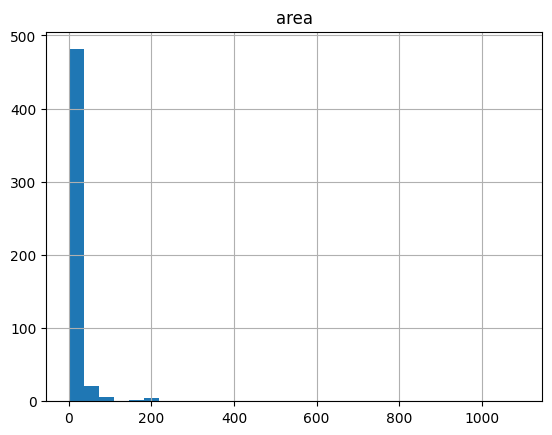

In [7]:
fire.hist('area',bins=30)

The data is heavily right skewed. This is expected as most fires are likely smaller fires with minimal area damage.

In [8]:
fire['area'].value_counts()

area
0.00      247
1.94        3
0.52        2
3.71        2
0.68        2
         ... 
105.66      1
154.88      1
196.48      1
200.94      1
11.16       1
Name: count, Length: 251, dtype: int64

We see that most of the fires have 0 or near-0 fire damage area.

Let's log transform our area outcome since it is heavily right-skewed. This will help distribute our data more symmetrically and hopefully make our model better.

array([[<Axes: title={'center': 'log_area'}>]], dtype=object)

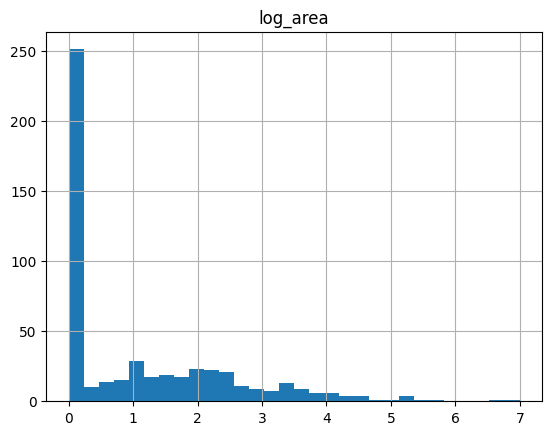

In [9]:
fire['log_area'] = np.log(fire['area']+1) #we add 1 as we can't log 0
fire.hist('log_area', bins=30)

Visually, the distribution is better, although still heavily skewed.

##### Month

Instead of using month directly, we'll derive another feature called summer that takes a value of 1 when the fire occurred during the summer. The idea here is that summer months are typically hotter, so fires are more likely.

In [10]:
summer = ["jun", "jul", "aug"]
fire['summer'] = fire['month'].apply(lambda x: 1 if x in summer else 0)
fire['summer'].value_counts()

summer
0    284
1    233
Name: count, dtype: int64

##### Imputing Missing Data <a class='anchor' id='4'></a>

In [11]:
fire.columns

Index(['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH',
       'wind', 'rain', 'area', 'log_area', 'summer'],
      dtype='object')

We will use K-Nearest Neighbor Imputation to fill in the missing values.

In [12]:
imp = KNNImputer(missing_values = np.nan, n_neighbors=3)

fire_missing = fire[fire.columns[4:12]] # FFMC to rain
imputed = pd.DataFrame(imp.fit_transform(fire_missing), 
                       columns = fire.columns[4:12])
imputed

,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,86.2,26.200000,94.300000,5.1,16.6,51.0,6.700000,0.0
1,90.6,56.433333,669.100000,6.7,18.0,33.0,0.900000,0.0
2,90.6,43.700000,470.833333,6.7,14.6,33.0,1.300000,0.0
3,91.7,33.300000,77.500000,9.0,8.3,97.0,4.000000,0.2
4,89.3,51.300000,102.200000,9.6,11.4,99.0,4.333333,0.0
...,...,...,...,...,...,...,...,...
512,81.6,56.700000,665.600000,1.9,27.8,32.0,2.700000,0.0
513,81.6,56.700000,665.600000,1.9,21.9,71.0,5.800000,0.0
514,81.6,56.700000,665.600000,1.9,21.2,70.0,6.700000,0.0
515,94.4,146.000000,614.700000,11.3,25.6,42.0,4.000000,0.0


##### Outliers Analysis <a class='anchor' id='5'></a>

<Axes: >

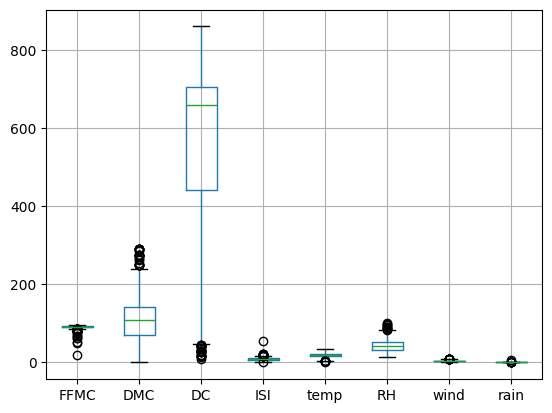

In [13]:
imputed.boxplot(column=["FFMC", "DMC", "DC", "ISI", "temp", "RH", "wind", "rain"])

The dots indicate outliers, so visually each predictor appears to have outliers.

In [14]:
for col in imputed:

    quartiles = np.percentile(fire[col], [25, 50, 75])
    iqr = quartiles[2] - quartiles[0]
    lower_bound = quartiles[0] - (1.5 * iqr)
    upper_bound = quartiles[2] + (1.5 * iqr)
    num_outliers =sum((imputed[col] < lower_bound) | (imputed[col] > upper_bound))

    print(f"The {col} column has {num_outliers} according to the boxplot method.")

The FFMC column has 0 according to the boxplot method.
The DMC column has 0 according to the boxplot method.
The DC column has 0 according to the boxplot method.
The ISI column has 0 according to the boxplot method.
The temp column has 0 according to the boxplot method.
The RH column has 0 according to the boxplot method.
The wind column has 0 according to the boxplot method.
The rain column has 0 according to the boxplot method.


Based on our calculations, there doesn't actually seem to be any outliers despite our boxplot.

##### Normalization <a class='anchor' id='6'></a>

Let's use our standardscaler to normalize our data.

In [15]:
scaler = StandardScaler()
scaled = scaler.fit_transform(imputed) #Normalize our predictors
scaled = pd.DataFrame(scaled, columns = fire.columns[4:12]) #Created dataframe of our normalized predictor

final = pd.concat([fire["summer"], scaled], axis=1) #Add summer column into our dataframe

final

,summer,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,0,-0.812283,-1.335942,-1.846711,-0.860187,-0.398187,0.418726,1.514159,-0.073268
1,0,-0.010735,-0.859009,0.509582,-0.508736,-0.155493,-0.715565,-1.761003,-0.073268
2,0,-0.010735,-1.059878,-0.303178,-0.508736,-0.744894,-0.715565,-1.535130,-0.073268
3,0,0.189652,-1.223939,-1.915580,-0.003526,-1.837021,3.317471,-0.010485,0.603155
4,0,-0.247556,-0.939988,-1.814327,0.128267,-1.299625,3.443503,0.177742,-0.073268
...,...,...,...,...,...,...,...,...,...
512,1,-1.650265,-0.854803,0.495235,-1.563087,1.543370,-0.778581,-0.744573,-0.073268
513,1,-1.650265,-0.854803,0.495235,-1.563087,0.520585,1.679050,1.005944,-0.073268
514,1,-1.650265,-0.854803,0.495235,-1.563087,0.399238,1.616034,1.514159,-0.073268
515,1,0.681511,0.553912,0.286579,0.501683,1.161993,-0.148419,-0.010485,-0.073268


#### Feature Selection <a class='anchor' id='7'></a>

Let's go ahead with both forward and backward sequential selection.

In [16]:
#Forward selection
y = fire["log_area"]

sfs_model = LinearRegression()
sfs_model2 = LinearRegression()
sfs_model3 = LinearRegression()

forward2 = SequentialFeatureSelector(estimator=sfs_model,
                                     n_features_to_select=2, 
                                     direction="forward")

forward4 = SequentialFeatureSelector(estimator=sfs_model2,
                                     n_features_to_select=4, 
                                     direction="forward")

forward6 = SequentialFeatureSelector(estimator=sfs_model3,
                                       n_features_to_select=6, 
                                       direction="forward")

forward2.fit(final, y)
forward4.fit(final, y)
forward6.fit(final, y)

print("Features selected in 2 feature model:", forward2.get_feature_names_out())
print("Features selected in 4 feature model:", forward4.get_feature_names_out())
print("Features selected in 6 feature model:", forward6.get_feature_names_out())

Features selected in 2 feature model: ['FFMC' 'DC']
Features selected in 4 feature model: ['FFMC' 'DC' 'RH' 'wind']
Features selected in 6 feature model: ['summer' 'FFMC' 'DC' 'ISI' 'RH' 'wind']


In [17]:
#Backward selection
backward2 = SequentialFeatureSelector(estimator=sfs_model,
                                     n_features_to_select=2, 
                                     direction="backward")

backward4 = SequentialFeatureSelector(estimator=sfs_model,
                                     n_features_to_select=4, 
                                     direction="backward")

backward6 = SequentialFeatureSelector(estimator=sfs_model,
                                       n_features_to_select=6, 
                                       direction="backward")

backward2.fit(final, y)
backward4.fit(final, y)
backward6.fit(final, y)

print("Features selected in 2 feature model:", backward2.get_feature_names_out())
print("Features selected in 4 feature model:", backward4.get_feature_names_out())
print("Features selected in 6 feature model:", backward6.get_feature_names_out())

Features selected in 2 feature model: ['DC' 'wind']
Features selected in 4 feature model: ['FFMC' 'DC' 'RH' 'wind']
Features selected in 6 feature model: ['summer' 'FFMC' 'DC' 'ISI' 'RH' 'wind']


DC is chosen in both forward and backward selection. FFMC and wind seems to be impactful as well.

We could proceed from this point with DC, FFMC, wind in a 3 feature model, but let us explore using regularization as well.

#### LASSO and Ridge Regularization <a class='anchor' id='8'></a>

In [19]:
ridge = RidgeCV(alphas = np.linspace(1, 10000, num=1000))
lasso = LassoCV(alphas = np.linspace(1, 10000, num=1000))

ridge.fit(final, y)
lasso.fit(final, y)

print("Ridge tuning parameter: ", ridge.alpha_)
print("Ridge coefficients: ", ridge.coef_)


Ridge tuning parameter:  1372.2342342342342
Ridge coefficients:  [-0.01455017  0.01311215  0.02006457  0.02004741 -0.01073465  0.01297049
 -0.01489714  0.02670554  0.00816103]


The Ridge alpha parameter is within range. Coefficients are all pretty small.

In [20]:
print("LASSO tuning parameter: ", lasso.alpha_)
print("LASSO coefficients: ", lasso.coef_)

LASSO tuning parameter:  10000.0
LASSO coefficients:  [-0.  0.  0.  0. -0.  0. -0.  0.  0.]


The LASSO alpha is at the extreme. None of the parameters are significant after regularization.

In [21]:
lasso = LassoCV(alphas = np.linspace(10000, 15000, num=1000))
lasso.fit(final, y)
print("LASSO tuning parameter: ", lasso.alpha_)
print("LASSO coefficients: ", lasso.coef_)

LASSO tuning parameter:  15000.0
LASSO coefficients:  [-0.  0.  0.  0. -0.  0. -0.  0.  0.]


The LASSO regularization is not helpful at this point as it seems with LASSO that none of the features are useful.

In [23]:
ridge = RidgeCV(alphas = np.linspace(1000, 1500, num=1000))
ridge.fit(final, y)
print("Ridge tuning parameter: ", ridge.alpha_)
print("Ridge coefficients: ", ridge.coef_)

Ridge tuning parameter:  1371.3713713713714
Ridge coefficients:  [-0.01455943  0.01311684  0.02007288  0.02005529 -0.01074213  0.0129749
 -0.01490353  0.02671898  0.00816454]


We will use the Ridge Regularization results along with our forward/backward selection in the K-Fold Cross Validation.

#### K-Fold Cross-Validation <a class='anchor' id='9'></a>

In [24]:
fw2_model = LinearRegression()
fw4_model = LinearRegression()
fw6_model = LinearRegression()

bw2_model = LinearRegression()
bw4_model = LinearRegression()
bw6_model = LinearRegression()

In [25]:
#Reference: two feature model comparison
reference_cv = cross_val_score(reference, final[["wind", "temp"]], y, cv = 5, scoring = "neg_mean_squared_error")

#Forward selection models
fw2_cv = cross_val_score(fw2_model, final[forward2.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
fw4_cv = cross_val_score(fw4_model, final[forward4.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
fw6_cv = cross_val_score(fw6_model, final[forward6.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")

#Backward selection models
bw2_cv = cross_val_score(bw2_model, final[backward2.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
bw4_cv = cross_val_score(bw4_model, final[backward4.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
bw6_cv = cross_val_score(bw6_model, final[backward6.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")

#Ridge Regularization models
ridge_cv = cross_val_score(ridge, final, y, cv = 5, scoring = "neg_mean_squared_error")

In [26]:
print("Reference Model, Avg Test MSE: ", np.mean(reference_cv), " SD: ", np.std(reference_cv))

Reference Model, Avg Test MSE:  -2.204650013004116  SD:  1.060040355378637


In [27]:
print("Forward-2 Model, Avg Test MSE: ", np.mean(fw2_cv), " SD: ", np.std(fw2_cv))
print("Forward-4 Model, Avg Test MSE: ", np.mean(fw4_cv), " SD: ", np.std(fw4_cv))
print("Forward-6 Model, Avg Test MSE: ", np.mean(fw6_cv), " SD: ", np.std(fw6_cv))

Forward-2 Model, Avg Test MSE:  -2.1735431721198535  SD:  1.0208083278697586
Forward-4 Model, Avg Test MSE:  -2.193528106772711  SD:  1.0004774710977682
Forward-6 Model, Avg Test MSE:  -2.239722553934875  SD:  1.0123323877770343


In [28]:
print("Backward-2 Model, Avg Test MSE: ", np.mean(bw2_cv), " SD: ", np.std(bw2_cv)) #Best performance
print("Backward-4 Model, Avg Test MSE: ", np.mean(bw4_cv), " SD: ", np.std(bw4_cv))
print("Backward-6 Model, Avg Test MSE: ", np.mean(bw6_cv), " SD: ", np.std(bw6_cv))

Backward-2 Model, Avg Test MSE:  -2.173357302739327  SD:  1.0038109503795953
Backward-4 Model, Avg Test MSE:  -2.193528106772711  SD:  1.0004774710977682
Backward-6 Model, Avg Test MSE:  -2.239722553934875  SD:  1.0123323877770343


In [29]:
print("Ridge Model, Avg Test MSE: ", np.mean(bw6_cv), " SD: ", np.std(bw6_cv))

Ridge Model, Avg Test MSE:  -2.239722553934875  SD:  1.0123323877770343


Backward-2 Model had the best performance with MSE at -2.17, followed by Forward-2 Model.

#### Conclusion <a class='anchor' id='10'></a>

In this project, we optimized the reference linear model via a few feature selection methods - ie forward, backward, and ridge methods. We found that backward-2 feature model had the lowest mean squared error.

Looking at the MSE in general, all of our models don't seem to be very good predictors. A likely explanation is the extreme skew in our data, which is not well represented by a linear regression model.